In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
import Colors
import JLD
import PyCall
import FileIO
using Statistics
using Plots

In [2]:
result_folder = "/Users/simon/Documents/DTU fag/Speciale/results/compare_snap_2"

"/Users/simon/Documents/DTU fag/Speciale/results/compare_snap_2"

## load the Snap results

In [3]:
rasterio = PyCall.pyimport("rasterio");

In [4]:
snap_tiff = rasterio.open("/Users/simon/Documents/DTU fag/Speciale/results/snap_result/subset_0_of_S1B_IW_SLC__1SDV_20200211T053200_20200211T053227_020217_026479_5817_Orb_Stack_ifg_deb_dinsar_TC.tif");
transform = snap_tiff.get_transform()
rows = collect(1:snap_tiff.height).-1;
columns = collect(1:snap_tiff.width).-1;
snap_lon = transform[1] .+ rows .* transform[2];
snap_lat = transform[4] .+ columns .* transform[6];

In [5]:
snap_tiff.meta

Dict{Any,Any} with 8 entries:
  "driver"    => "GTiff"
  "dtype"     => "float32"
  "height"    => 2697
  "nodata"    => nothing
  "count"     => 3
  "width"     => 3366
  "transform" => (0.000124417, 0.0, 9.42211, 0.0, -0.000124417, 55.7553, 0.0, 0…
  "crs"       => PyObject CRS.from_epsg(4326)

In [6]:
bands = [snap_tiff.read(i) for i in 1:3]
maxmin = [(minimum(reshape(elem,:)),maximum(reshape(elem,:))) for elem in bands]

3-element Array{Tuple{Float32,Float32},1}:
 (0.0, 7.258769e17)    
 (-3.134217, 3.1415927)
 (0.0, 0.9797358)      

In [7]:
snap_phase = exp.(bands[2].*im);
snap_coh = bands[3];

In [8]:
FileIO.save(joinpath(result_folder,"snap_coherence.png"),Colors.Gray.(snap_coh ));
FileIO.save(joinpath(result_folder,"snap_coherence_phase.png"),SlcUtil.plot_phase(snap_phase));

## Get own results

In [9]:
own_gamma = JLD.load(joinpath(result_folder,"21VV_coher.jld"),"data")
FileIO.save(joinpath(result_folder,"own_coherence.jpg"),Colors.Gray.(abs.(own_gamma)));
FileIO.save(joinpath(result_folder,"own_coherence_phase.png"),SlcUtil.plot_phase(own_gamma));

In [10]:
line_sample = JLD.load(joinpath(result_folder,"line_sample.jld"))
samples = collect(line_sample["samples"]) #[1:7:end]
lines =collect(line_sample["lines"]) #[1:2:end]
lut = JLD.load(joinpath(result_folder,"21_lut.jld"),"data");

In [11]:
own_lat = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["latitude"],(length(lut["master_line"]),length(lut["master_sample"])))
, lines,samples)
own_lon = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["longitude"],(length(lut["master_line"]),length(lut["master_sample"])))
,lines,samples);

## Resample snap results

In [12]:
ndimage = PyCall.pyimport("scipy.ndimage");

In [13]:
idx1 = reshape((own_lat.-transform[4])./(transform[6]),:)
idx2 = reshape((own_lon.-transform[1])./transform[2],:);
index = [idx1,idx2];

snap_coh_re = ndimage.map_coordinates(snap_coh, index, order=1, mode="constant");
snap_coh_re= reshape(snap_coh_re,size(own_gamma));

In [14]:
snap_phase_re = ndimage.map_coordinates(real.(snap_phase), index, order=1, mode="constant") .+ ndimage.map_coordinates(imag.(snap_phase), index, order=1, mode="constant").*im;
snap_phase_re= reshape(snap_phase_re,size(own_gamma));

In [15]:
FileIO.save(joinpath(result_folder,"snap_coherence_re.png"),Colors.Gray.(snap_coh_re ));
FileIO.save(joinpath(result_folder,"snap_coherence_phase_re.png"),SlcUtil.plot_phase(snap_phase_re));

## Compare

In [16]:
img = Colors.RGB{Float32}.(abs.(own_gamma),snap_coh_re,snap_coh_re);
FileIO.save(joinpath(result_folder,"ownSnapSnap_coherence.png"),img);

In [17]:
delta_phase = own_gamma .* conj.(snap_phase_re)
delta_phase[(snap_phase_re .== 0) .| (snap_phase_re .== 1)] .= 0
FileIO.save(joinpath(result_folder,"delta_phase.png"),SlcUtil.plot_phase(delta_phase));

In [46]:
delta_cohe = abs.(abs.(own_gamma).- snap_coh_re)
delta_cohe[snap_coh_re .==0] .=0
delta_cohe=delta_cohe./0.1
delta_cohe[delta_cohe .> 1] .=1
FileIO.save(joinpath(result_folder,"diff_coherence.png"),Colors.Gray.(delta_cohe./2));


### Histogram

In [19]:
delta_cohe = (abs.(own_gamma).- snap_coh_re)
delta_cohe = reshape(delta_cohe,:)
delta_cohe = delta_cohe[reshape(snap_coh_re,:) .!=0];

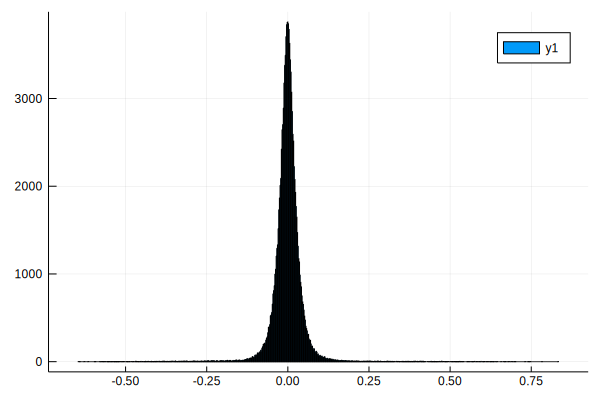

In [20]:
histogram(delta_cohe)

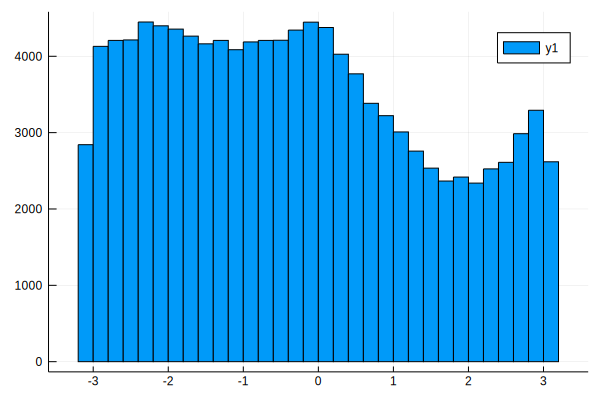

In [21]:
delta = reshape(delta_phase,:)
delta = delta[delta .!= 0];
histogram(angle.(delta))

# Sigma 0

In [22]:
rasterio = PyCall.pyimport("rasterio");
function db_scale_img(img , min , max)
    log_img = (10*log10.(img).-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end

min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

-3

### Load Snap results

In [23]:
snap_tiff = rasterio.open("/Users/simon/Documents/DTU fag/Speciale/results/snap_result/subset_1_of_S1A_IW_SLC__1SDV_20200217T053252_20200217T053319_031288_03996E_8F3C_split_Orb_Cal_deb_Spk_TC.tif");
transform = snap_tiff.get_transform()
rows = collect(1:snap_tiff.height).-1;
columns = collect(1:snap_tiff.width).-1;
snap_lon = transform[1] .+ rows .* transform[2];
snap_lat = transform[4] .+ columns .* transform[6];

In [24]:
bands = [snap_tiff.read(i) for i in 1:2];

In [25]:
img = Colors.Gray.(db_scale_img(bands[2].+ 10^(-5),min_vv,max_vv));
FileIO.save(joinpath(result_folder,"snap_intenens_VV.png"),img );
img = Colors.Gray.(db_scale_img(bands[1].+ 10^(-5),min_vh,max_vh));
FileIO.save(joinpath(result_folder,"snap_intenens_VH.png"),img );

## Get own results

In [26]:
own_VV = JLD.load(joinpath(result_folder,"1VV_itens.jld"),"data")
own_VH = JLD.load(joinpath(result_folder,"1VH_itens.jld"),"data");

In [27]:
img = Colors.Gray.(db_scale_img(own_VV,min_vv,max_vv));
FileIO.save(joinpath(result_folder,"own_intenens_VV.jpg"),img );
img = Colors.Gray.(db_scale_img(own_VH,min_vh,max_vh));
FileIO.save(joinpath(result_folder,"own_intenens_VH.jpg"),img );

In [28]:
line_sample = JLD.load(joinpath(result_folder,"line_sample.jld"))
samples = collect(line_sample["samples"]) #[1:7:end]
lines = collect(line_sample["lines"]) #[1:2:end]
lut = JLD.load(joinpath(result_folder,"21_lut.jld"),"data");

own_lat = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["latitude"],(length(lut["master_line"]),length(lut["master_sample"])))
, lines,samples)
own_lon = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["longitude"],(length(lut["master_line"]),length(lut["master_sample"])))
,lines,samples);

## Resample snap results

In [29]:
ndimage = PyCall.pyimport("scipy.ndimage");

In [30]:
idx1 = reshape((own_lat.-transform[4])./(transform[6]),:)
idx2 = reshape((own_lon.-transform[1])./transform[2],:);
index = [idx1,idx2];
bands_re = [ndimage.map_coordinates(elem, index, order=1, mode="constant") for elem in bands];
bands_re  = [reshape(elem,size(own_VV)) for elem in bands_re];

In [31]:
img = Colors.Gray.(db_scale_img(bands_re[2].+ 10^(-5),min_vv,max_vv));
FileIO.save(joinpath(result_folder,"snap_intenens_VV_resampled.png"),img );
img = Colors.Gray.(db_scale_img(bands_re[1].+ 10^(-5),min_vh,max_vh));
FileIO.save(joinpath(result_folder,"snap_intenens_VH_resampled.png"),img );

## Compare

In [32]:
snap = copy(bands_re[2])
snap[snap.==0] .= 10^(-5)
snap = db_scale_img(snap,min_vv,max_vv)
own = db_scale_img(own_VV,min_vv,max_vv)

img = Colors.RGB{Float32}.(own,snap,snap);
FileIO.save(joinpath(result_folder,"ownSnapSnap_intensity_VV.png"),img);

In [33]:
snap = copy(bands_re[1])
snap[snap.==0] .= 10^(-5)
snap = db_scale_img(snap,min_vh,max_vh)
own = db_scale_img(own_VH,min_vh,max_vh)

img = Colors.RGB{Float32}.(own,snap,snap);
FileIO.save(joinpath(result_folder,"ownSnapSnap_intensity_VH.png"),img);

In [34]:
delta = (bands_re[2].-own_VV)./0.1;
delta[bands_re[2] .== 0] .= 0
delta[delta .<0] .= 0
delta[delta .>1] .= 1

FileIO.save(joinpath(result_folder,"diff_VV.png"),Colors.Gray.(delta));

In [35]:
delta = (own_VV./bands_re[2]);
delta = 1 .- delta
delta[bands_re[2] .== 0] .= 0
delta[delta .>1] .= 1

red = copy(delta)
a  = sum(sum(delta .<0))
red[delta .<0] .= 1
delta[delta .<0] .= 0



img = Colors.RGB{Float32}.(red,delta,delta)

FileIO.save(joinpath(result_folder,"diff_VV_raio.png"),img);

In [36]:
a

1070

### Histogram 

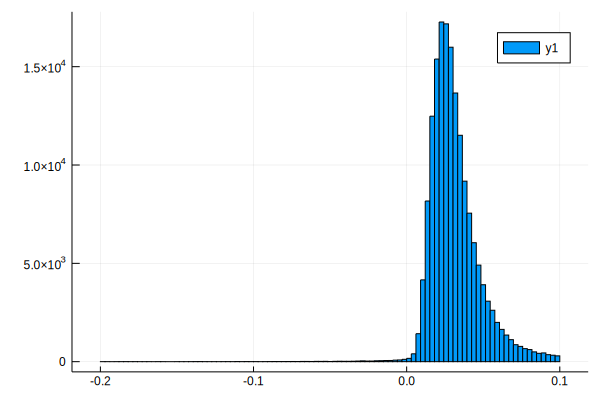

In [37]:
delta = (bands_re[2].-own_VV);
delta = reshape(delta,:)
delta = delta[reshape(bands_re[2],:) .!=0];
histogram(delta,bins=range(-0.2,stop =0.1, length = 100))

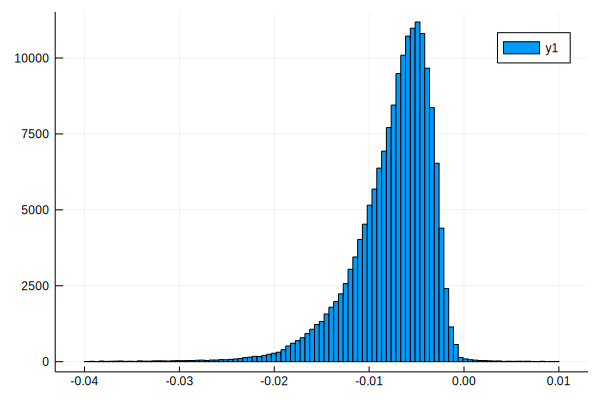

In [38]:
delta = (own_VH.- bands_re[1])
delta = reshape(delta,:)
delta = delta[reshape(bands_re[2],:) .!=0];
histogram(delta,bins=range(-0.04,stop =0.01, length = 100))

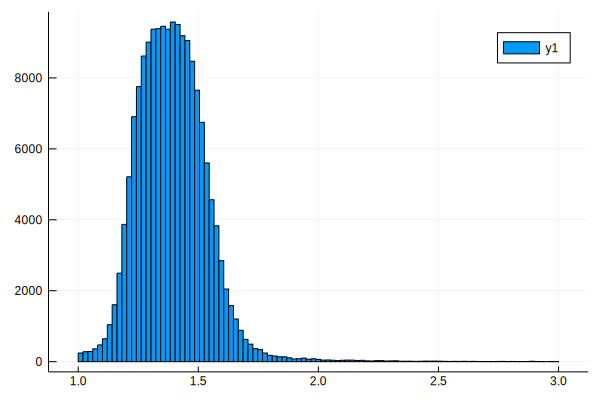

In [39]:
delta = (bands_re[2]./own_VV)
delta = reshape(delta,:)
delta = delta[reshape(bands_re[2],:) .!=0];
delta[delta .<1 ] .= 1 ./delta[delta .<1 ];
histogram(delta,bins=range(1,stop =3, length = 100))

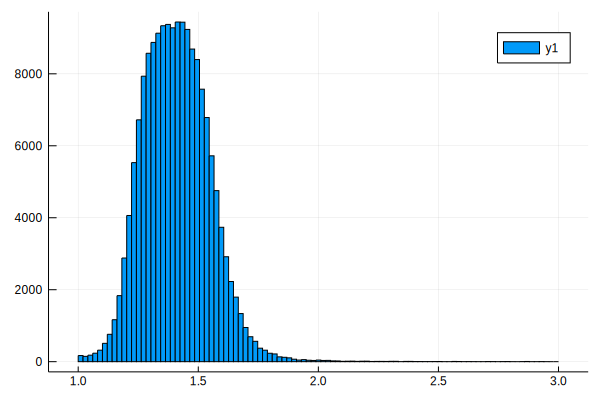

In [40]:
delta = (bands_re[1]./own_VH)
delta = reshape(delta,:)
delta = delta[reshape(bands_re[2],:) .!=0];
delta[delta .<1 ] .= 1 ./delta[delta .<1 ];
histogram(delta,bins=range(1,stop =3, length = 100))